# Линейная регрессия

## Цели работы:

* реализовать два способа решения задачи линейной регрессии;
* настроить гиперпараметры у каждого алгоритма, в частности параметры одного из методов регуляризации;
* анализ результатов.

### Метод наименьших квадратов (используя псевдообратную матрицу и сингулярное разложение)

Подключение библиотек

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from lib import SVDRegressor
from lib import rmse
from lib import nrmse
from lib import smape
from lib import MinMaxScaler

Считываем тренировочный и тестовый датасет

In [4]:
f = open("LR/3.txt", "r")
n_features = int(f.readline())
n_train_objects = int(f.readline())
y_train = []
X_train = []
for i in range(n_train_objects):
    nums: [int] = list(map(int, f.readline().split()))
    y_train.append(nums.pop())
    X_train.append(nums)
n_test_objects = int(f.readline())
y_test = []
X_test = []
for i in range(n_test_objects):
    nums: [int] = list(map(int, f.readline().split()))
    y_test.append(nums.pop())
    X_test.append(nums)

Проводим подбор параметров для гребневой регрессии

In [12]:
nrmses = []
rmses = []
params = []


smapes = []


for par in range(0, 4000, 200):
    regressor = SVDRegressor()
    regressor.fit(X_train, y_train,reg_param=par)
    predicted = regressor.predict(X_test)
    print(regressor.w)
    smapes.append(smape(y_test, predicted))
    rmses.append(rmse(y_test, predicted))
    nrmses.append(nrmse(y_test, predicted))
    params.append(par)

[92110.087087778, -60231.463201393075, -116868365826755.22, 31994.564315708445, 299681795584071.3, 80523.31335392717, 73933.04008508875, 37445.42037487837, -1297535530887608.8]
[-2.118700971289859, 3.935323859116351, 0.2601432882975172, 10.14346111634643, -1.5246365422301726, 12.968503616221504, -11.641486452796102, 3.7329566839952872, -0.37556454207207607]
[-0.9882011654988233, 1.938856522218458, 0.2601432463604591, 4.9401881326912545, -1.5246362932647441, 6.3828329789524245, -6.018894937865995, 2.3496627902605933, -0.37556448082950317]
[-0.606362793532968, 1.2708317578211676, 0.2601432322850785, 3.1990459128634967, -1.5246362097089223, 4.181038145365785, -4.137991188646585, 1.8864286885966783, -0.37556446027533985]
[-0.41449987556945356, 0.9363422095130298, 0.26014322522845945, 2.327208907915186, -1.524636167819586, 3.0789038354067046, -3.196276353160403, 1.6544090843394692, -0.3755644499707696]
[-0.29907945175701645, 0.7354955650736286, 0.26014322098792786, 1.8037008089848858, -1.52

строим графики зависимости NRMSE, RMSE от параметра гребневой регуляризации

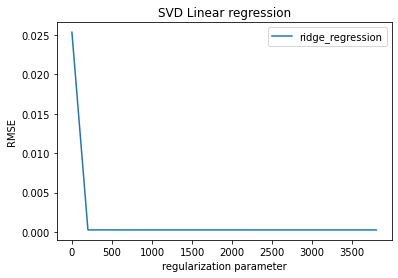

In [9]:
plt.plot(params, smapes, label='ridge_regression')
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.title("SVD Linear regression")
plt.legend()
plt.show()

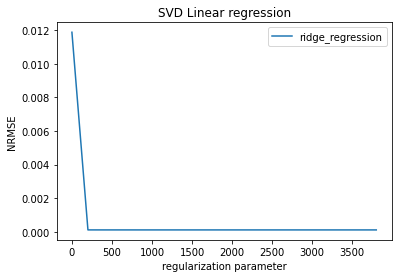

In [10]:
plt.plot(params, nrmses, label='ridge_regression')
plt.xlabel('regularization parameter')
plt.ylabel('NRMSE')
plt.title("SVD Linear regression")
plt.legend()
plt.show()

In [8]:
print(np.min(rmses))
print(params[np.argmin(rmses)])

643.793704681601
3800


### Градиентный спуск

Считываем датасет

In [7]:
f = open("LR/4.txt", "r")
n_features = int(f.readline())
n_train_objects = int(f.readline())
y_train = []
X_train = []
for i in range(n_train_objects):
    nums: [int] = list(map(int, f.readline().split()))
    y_train.append(nums.pop())
    X_train.append(nums)
n_test_objects = int(f.readline())
y_test = []
X_test = []
for i in range(n_test_objects):
    nums: [int] = list(map(int, f.readline().split()))
    y_test.append(nums.pop())
    X_test.append(nums)
    
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_transposed = np.transpose(X_train)

y_scaler = MinMaxScaler()

y_scaler.fit_transform_vector(y_train)
y_scaler.transform_vector(y_test)



In [8]:
def grad_mse(x: [float], y: float, w: [float]) -> [float]:
    predicted = predict_value(x, w)
    grad = []
    for i in range(len(x)):
        grad.append(2 * x[i] * (predicted - y))
    grad.append(2 * (predicted - y))
    return grad

In [9]:
def initialize_weights(n: int) -> [float]:
    return [random.uniform(-1 / (2 * n), 1 / (2 * n)) for _ in range(n)]

In [10]:
from lib import mse_single
loss_function = mse_single

In [11]:
def predict_value(x: [float], weights: [float]) -> float:
    predicted = 0
    for i in range(len(x)):
        predicted += weights[i] * x[i]
    predicted += weights[len(weights) - 1]
    return predicted

In [12]:
def norm(x: [float]) -> float:
    res = 0
    for i in range(len(x)):
        res += x[i] ** 2
    res = np.sqrt(res)
    return res + 0.000000001

In [13]:
def normalized_vector(x: [float]) -> [float]:
    res = []

    x_norm = norm(x)
    for i in range(len(x)):
        res.append(x[i] / x_norm)
    return res

In [14]:
def SGD(X: [[float]], y: [float], l: float, grad_num=1, max_iter=5, tau: float = 0, learning_rate=0.1) -> [float]:
    random.seed(42)
    n = len(X)
    w = initialize_weights(len(X[0]) + 1)
    Q = 0
    for i in range(n):
        Q += loss_function(y[i], predict_value(X[i], w))
    Q /= n

    Q += (norm(w) ** 2) * tau / 2
    for iter in range(max_iter):
        Q_last = Q
        h = 1 / (iter + 1)
        gradient = [0 for _ in range(len(w))]
        eps = 0
        for _ in range(grad_num):
            i = random.randint(0, n - 1)
            gr_tmp = grad_mse(X[i], y[i], w)
            eps_tmp = loss_function(y[i], predict_value(X[i], w))
            for j in range(len(gradient)):
                gradient[j] += gr_tmp[j]
            eps += eps_tmp
        eps /= grad_num
        for j in range(len(gradient)):
            gradient[j] /= grad_num

        gradient = normalized_vector(gradient)
        for j in range(len(w)):
            w[j] = w[j] * (1 - h * tau) - h * gradient[j]
        Q = (1 - l) * Q + l * eps
        if (abs(Q_last - Q) < learning_rate):
            break

        iter += 1

    return w

[0.06706580142340741, 0.0951974504285036, 0.10415721192891625, 0.08352391111888893, 0.08519498320361515, 0.10429369650820694, 0.08648957711684249, 0.0984868307901612, 0.14023830543784696, 0.09783887030005342, 0.10402646460094636, 0.10288120417330542, 0.10626234808373441, 0.11450325494100787, 0.10690306657896408, 0.12318115581843639, 0.11898816291345952, 0.11784264388096367, 0.12333610637582829, 0.11299656676764508, 0.12617204587871775, 0.1145767756163825, 0.11880445176678803, 0.11935575347016512, 0.12114143832674829, 0.12165094333796968, 0.11978105800236806, 0.1194690849256136, 0.17630181360412278, 0.12229809870565181, 0.11941479654232706, 0.1228199511500596, 0.12236549998355344, 0.12153134602085915, 0.12416420633940793, 0.1278116129519173, 0.12635380982403857, 0.12787533355808, 0.12460016651860661, 0.12619349787609496, 0.13478966893260552, 0.1294034530634214, 0.12669276312342193, 0.12869292140531433, 0.12833848482754692, 0.1307484771597848, 0.1283900902186818, 0.12754644270511695, 0.1

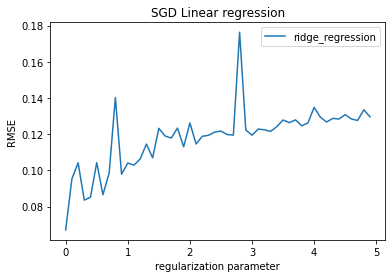

In [17]:
taus = []
rmses = []
for i in np.arange(0,5,0.1):
    taus.append(i)
    w = SGD(X_train, y_train, l=0.5, grad_num=20, max_iter=2000, tau=i, learning_rate=0.00001)
    predicted = []
    for j in range(n_test_objects):
        predicted.append(predict_value(X_test[j], w))
    rmses.append(rmse(y_test, predicted))
print(rmses)
plt.plot(taus, rmses, label='ridge_regression')
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.title("SGD Linear regression")
plt.legend()
plt.show()

In [21]:
taus = []
rmses = []
for i in np.arange(0,5,0.5):
    taus.append(i)
    w = SGD(X_train, y_train, l=0.5, grad_num=20, max_iter=2000, tau=i, learning_rate=0.00001)
    predicted = []
    for j in range(n_train_objects):
        predicted.append(predict_value(X_train[j], w))
    rmses.append(rmse(y_train, predicted))
    print(rmses[len(rmses)-1])
print(rmses)
plt.plot(taus, rmses, label='ridge_regression')
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.title("SGD Linear regression")
plt.legend()
plt.show()

0.0688355859233068
0.10570996230688876
0.10524369721574003
0.12345615074101444
0.12598164518766752
0.12245550751517019
0.11985189947058765
0.12763261507261375
0.13423612340673063


KeyboardInterrupt: 